In [17]:
import os

dataset_path = "polo"
items_path = os.path.join(dataset_path, "items")
json_path = os.path.join(dataset_path, "json")
mask_path = os.path.join(dataset_path, "mask")

items_files = sorted(os.listdir(items_path))
json_files = sorted(os.listdir(json_path))
mask_files = sorted(os.listdir(mask_path))

assert len(items_files) == len(json_files) == len(mask_files) == 132, "Ошибка: количество файлов не совпадает!"

for i, (item_file, json_file, mask_file) in enumerate(zip(items_files, json_files, mask_files), start=1):
    new_item_name = f"{i}.jfif"
    new_json_name = f"{i}.json"
    new_mask_name = f"{i}.png"

    os.rename(os.path.join(items_path, item_file), os.path.join(items_path, new_item_name))
    os.rename(os.path.join(json_path, json_file), os.path.join(json_path, new_json_name))
    os.rename(os.path.join(mask_path, mask_file), os.path.join(mask_path, new_mask_name))

print("Файлы поменял на номерные")

Файлы поменял на номерные


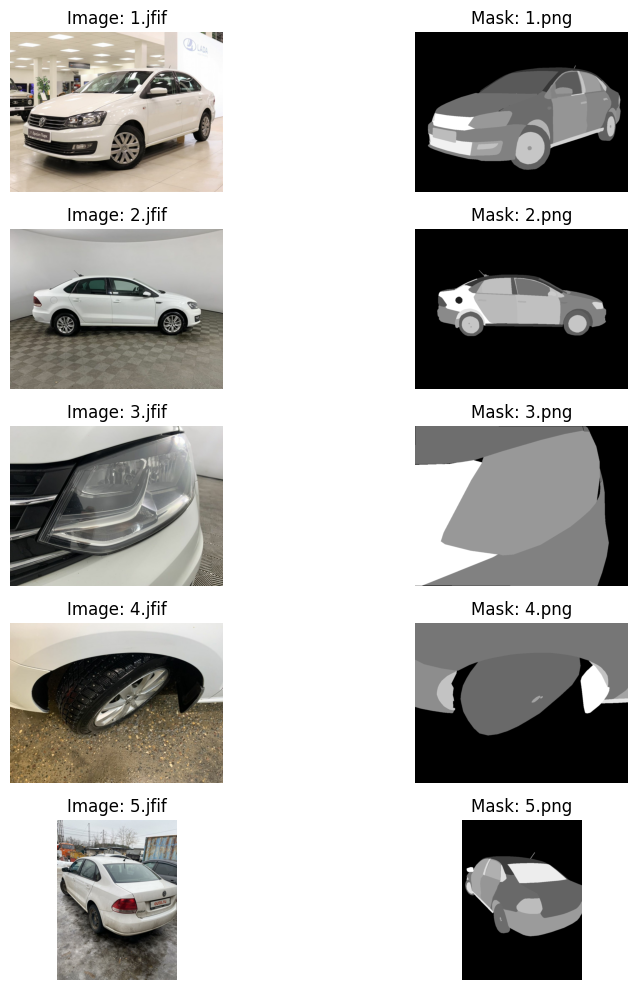

In [18]:
import matplotlib.pyplot as plt
import cv2
import os


images_path = "polo/items"
masks_path = "polo/mask"

image_files = sorted(os.listdir(images_path), key=lambda x: int(os.path.splitext(x)[0]))
mask_files = sorted(os.listdir(masks_path), key=lambda x: int(os.path.splitext(x)[0]))
num_samples = 5
num_samples = min(num_samples, len(image_files), len(mask_files))

fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10))

for i in range(num_samples):
    img = cv2.imread(os.path.join(images_path, image_files[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(os.path.join(masks_path, mask_files[i]), cv2.IMREAD_GRAYSCALE)

    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Image: {image_files[i]}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask, cmap="gray")
    axes[i, 1].set_title(f"Mask: {mask_files[i]}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [23]:
import numpy as np
import json
import pathlib

class_mapping = {
    "Крупные детали.Бампер задний": 0,
    "Крупные детали.Бампер передний": 1,
    "Крупные детали.Дверь задняя левая": 2,
    "Крупные детали.Дверь задняя правая": 3,
    "Крупные детали.Дверь передняя левая": 4,
    "Крупные детали.Дверь передняя правая": 5,
    "Крупные детали.Капот": 6,
    "Крупные детали.Колесо": 7,
    "Крупные детали.Крыло заднее левое": 8,
    "Крупные детали.Крыло заднее правое": 9,
    "Крупные детали.Крыло переднее левое": 10,
    "Крупные детали.Крыло переднее правое": 11,
    "Крупные детали.Крыша": 12,
    "Крупные детали.Крышка багажника": 13,
    "Крупные детали.Лобовое стекло": 14,
    "Крупные детали.Стекло кузова заднее": 15,
    "Мелкие детали.Антенна": 16,
    "Мелкие детали.Болты крепления диска колеса": 17,
    "Мелкие детали.Заглушка буксировочного крюка бампера переднего": 18,
    "Мелкие детали.Заглушка для диска колеса": 19,
    "Мелкие детали.Крышка бокового зеркала левая": 20,
    "Мелкие детали.Крышка бокового зеркала правая": 21,
    "Мелкие детали.Левая щетка стеклоочистителя на лобовое стекло": 22,
    "Мелкие детали.Левый поводок стеклоочистителя на лобовое стекло": 23,
    "Мелкие детали.Молдинг стекла двери задней левой наружный": 24,
    "Мелкие детали.Молдинг стекла двери задней правой наружный": 25,
    "Мелкие детали.Молдинг стекла двери передней левой наружный": 26,
    "Мелкие детали.Молдинг стекла двери передней правой наружный": 27,
    "Мелкие детали.Ниппель автомобильный для колеса": 28,
    "Мелкие детали.Повторитель": 29,
    "Мелкие детали.Правая щетка стеклоочистителя на лобовое стекло": 30,
    "Мелкие детали.Правый поводок стеклоочистителя на лобовое стекло": 31,
    "Мелкие детали.ПТФ левый": 32,
    "Мелкие детали.ПТФ правый": 33,
    "Мелкие детали.Решетка стеклоочистителя (Накладка жабо под стеклоочистители)": 34,
    "Мелкие детали.Ручка двери": 35,
    "Мелкие детали.Фонарь катафот левый в задний бампер": 36,
    "Мелкие детали.Фонарь катафот правый в задний бампер": 37,
    "Мелкие детали.Шильдик марки автомобиля": 38,
    "Мелкие детали.Эмблема": 39,
    "Средние детали.Боковое зеркало левое": 40,
    "Средние детали.Боковое зеркало правое": 41,
    "Средние детали.Брызговик задний левый": 42,
    "Средние детали.Брызговик задний правый": 43,
    "Средние детали.Брызговик передний левый": 44,
    "Средние детали.Брызговик передний правый": 45,
    "Средние детали.Диск колеса": 46,
    "Средние детали.Крышка люка бензобака": 47,
    "Средние детали.Молдинг бампера заднего центральный": 48,
    "Средние детали.Молдинг зеркала левый": 49,
    "Средние детали.Молдинг зеркала правый": 50,
    "Средние детали.Накладка на порог левый": 51,
    "Средние детали.Накладка на порог правый": 52,
    "Средние детали.Накладка центральной стойки левая наружная": 53,
    "Средние детали.Накладка центральной стойки правая наружная": 54,
    "Средние детали.Подкрылок задний левый": 55,
    "Средние детали.Подкрылок задний правый": 56,
    "Средние детали.Подкрылок передний левый": 57,
    "Средние детали.Подкрылок передний правый": 58,
    "Средние детали.Рамка гос номера": 59,
    "Средние детали.Решетка бампера центральная": 60,
    "Средние детали.Решетка переднего бампера под ПТФ левая": 61,
    "Средние детали.Решетка переднего бампера под ПТФ правая": 62,
    "Средние детали.Решетка радиатора": 63,
    "Средние детали.Стекло двери задней левой": 64,
    "Средние детали.Стекло двери задней левой (форточка)": 65,
    "Средние детали.Стекло двери задней правой": 66,
    "Средние детали.Стекло двери задней правой (форточка)": 67,
    "Средние детали.Стекло двери передней левой": 68,
    "Средние детали.Стекло двери передней правой": 69,
    "Средние детали.Фара передняя левая": 70,
    "Средние детали.Фара передняя правая": 71,
    "Средние детали.Фонарь задний левый": 72,
    "Средние детали.Фонарь задний правый": 73
}

In [21]:
annotations_dir = "polo/json"

for root, _, files in os.walk(annotations_dir):
    for file in files:
        if file.endswith(".json"):
            json_path = os.path.join(root, file)
            
            with open(json_path, "r", encoding="utf-8") as f:
                data = json.load(f)

            modified = False

            if "annotations" in data:
                for ann in data["annotations"]:
                    old_label = ann.get("label")
                    if old_label in class_mapping:
                        ann["label"] = class_mapping[old_label]
                        modified = True

            if modified:
                with open(json_path, "w", encoding="utf-8") as f:
                    json.dump(data, f, ensure_ascii=False, indent=2)
                print(f" Updated: {json_path}")

 Updated: polo/json\1.json
 Updated: polo/json\10.json
 Updated: polo/json\100.json
 Updated: polo/json\101.json
 Updated: polo/json\102.json
 Updated: polo/json\103.json
 Updated: polo/json\104.json
 Updated: polo/json\105.json
 Updated: polo/json\106.json
 Updated: polo/json\107.json
 Updated: polo/json\108.json
 Updated: polo/json\109.json
 Updated: polo/json\11.json
 Updated: polo/json\110.json
 Updated: polo/json\111.json
 Updated: polo/json\112.json
 Updated: polo/json\113.json
 Updated: polo/json\114.json
 Updated: polo/json\115.json
 Updated: polo/json\116.json
 Updated: polo/json\117.json
 Updated: polo/json\118.json
 Updated: polo/json\119.json
 Updated: polo/json\12.json
 Updated: polo/json\120.json
 Updated: polo/json\121.json
 Updated: polo/json\122.json
 Updated: polo/json\123.json
 Updated: polo/json\124.json
 Updated: polo/json\125.json
 Updated: polo/json\126.json
 Updated: polo/json\127.json
 Updated: polo/json\128.json
 Updated: polo/json\129.json
 Updated: polo/json

In [ ]:
import os
import json
import cv2


dataset_path = "polo"
images_path = os.path.join(dataset_path, "items")
jsons_path = os.path.join(dataset_path, "json")
output_labels_path = "dataset/labels"


os.makedirs(output_labels_path, exist_ok=True)


for json_file in os.listdir(jsons_path):
    json_path = os.path.join(jsons_path, json_file)
    image_filename = json_file.replace(".json", ".jfif")
    image_path = os.path.join(images_path, image_filename)

    if not os.path.exists(image_path):
        continue

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    img = cv2.imread(image_path)
    h, w, _ = img.shape

    label_txt_path = os.path.join(output_labels_path, json_file.replace(".json", ".txt"))

    with open(label_txt_path, "w") as label_file:
        for ann in data["annotations"]:
            label = ann["label"]

            
            if isinstance(label, str) and label in class_mapping:
                label = class_mapping[label]

            if "coordinates" not in ann:
                print(f"Пропущен объект '{label}': нет ключа 'coordinates'!")
                continue

            if isinstance(ann["coordinates"], str):
                ann["coordinates"] = ann["coordinates"].strip()
                if ann["coordinates"]:
                    try:
                        ann["coordinates"] = json.loads(ann["coordinates"])
                    except json.JSONDecodeError:
                        print(f"Ошибка парсинга JSON в '{label}', пропускаем.")
                        continue
                else:
                    ann["coordinates"] = []

            if not isinstance(ann["coordinates"], list) or not ann["coordinates"]:
                print(f"Пропущен объект '{label}' без координат!")
                continue

            try:
                coordinates = []
                for poly in ann["coordinates"]:
                    for p in poly:
                        coordinates.append([p["x"], p["y"]])

                coordinates_str = ' '.join([f"{x:.6f},{y:.6f}" for x, y in coordinates])
                label_file.write(f"{label} {coordinates_str}\n")

            except ValueError:
                print(f"Ошибка: пустой полигон в '{label}', пропускаем.")
                continue


Пропущен объект '7' без координат!
Пропущен объект '7' без координат!
Пропущен объект '17' без координат!
Пропущен объект '17' без координат!
Пропущен объект '17' без координат!
Пропущен объект '19' без координат!
Пропущен объект '17' без координат!
Пропущен объект '17' без координат!
Пропущен объект '7' без координат!
Пропущен объект '3': нет ключа 'coordinates'!
Пропущен объект '50': нет ключа 'coordinates'!
Пропущен объект '7' без координат!
Пропущен объект '68': нет ключа 'coordinates'!
Пропущен объект '5': нет ключа 'coordinates'!
Ошибка парсинга JSON в '46', пропускаем.
Пропущен объект '5': нет ключа 'coordinates'!
Пропущен объект '7' без координат!


In [26]:
import os
import cv2

images_path = "polo/items"  
output_labels_path = "dataset/labels"  

def normalize_coordinates(image_path, label_txt_path, output_label_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Не удалось загрузить изображение {image_path}")
        return

    image_height, image_width, _ = img.shape

    if not os.path.exists(label_txt_path):
        print(f"Файл аннотаций не найден: {label_txt_path}")
        return

    with open(label_txt_path, "r") as label_file:
        annotations = label_file.readlines()

    normalized_annotations = []

    for ann in annotations:
        ann_data = ann.split()
        if len(ann_data) < 2:
            continue 

        class_id = ann_data[0] 
        coordinates = ann_data[1:]  

        polygon = []
        for coord in coordinates:
            try:
                x, y = map(float, coord.split(','))
                x_normalized = x / image_width
                y_normalized = y / image_height
                polygon.append((x_normalized, y_normalized))
            except ValueError:
                print(f"Ошибка при обработке координат: {coord}")
                continue

        if polygon:
            normalized_annotations.append(f"{class_id} " + " ".join([f"{x:.6f},{y:.6f}" for x, y in polygon]))

    with open(output_label_path, "w") as label_file:
        for ann in normalized_annotations:
            label_file.write(ann + "\n")

    print(f"Нормализованные аннотации сохранены в {output_label_path}")

for label_file in os.listdir(output_labels_path):
    if label_file.endswith(".txt"):
        label_txt_path = os.path.join(output_labels_path, label_file)
        image_filename = label_file.replace(".txt", ".jfif")
        image_path = os.path.join(images_path, image_filename)

        if not os.path.exists(image_path):
            print(f"Изображение не найдено: {image_path}")
            continue

        output_label_path = label_txt_path 
        normalize_coordinates(image_path, label_txt_path, output_label_path)


Нормализованные аннотации сохранены в dataset/labels\1.txt
Нормализованные аннотации сохранены в dataset/labels\10.txt
Нормализованные аннотации сохранены в dataset/labels\100.txt
Нормализованные аннотации сохранены в dataset/labels\101.txt
Ошибка при обработке координат: детали.Решетка
Ошибка при обработке координат: стеклоочистителя
Ошибка при обработке координат: (Накладка
Ошибка при обработке координат: жабо
Ошибка при обработке координат: под
Ошибка при обработке координат: стеклоочистители)
Нормализованные аннотации сохранены в dataset/labels\102.txt
Нормализованные аннотации сохранены в dataset/labels\103.txt
Нормализованные аннотации сохранены в dataset/labels\104.txt
Ошибка при обработке координат: детали.Решетка
Ошибка при обработке координат: стеклоочистителя
Ошибка при обработке координат: (Накладка
Ошибка при обработке координат: жабо
Ошибка при обработке координат: под
Ошибка при обработке координат: стеклоочистители)
Нормализованные аннотации сохранены в dataset/labels\1

In [ ]:
import os

labels_path = "dataset/labels"

for label_file in os.listdir(labels_path):
    label_txt_path = os.path.join(labels_path, label_file)

    if label_file.endswith(".txt"):
        try:
            with open(label_txt_path, "r", encoding="utf-8", errors="ignore") as file:
                content = file.read()
        except UnicodeDecodeError:
            # Если ошибка, другую кодировку
            with open(label_txt_path, "r", encoding="ISO-8859-1", errors="ignore") as file:
                content = file.read()

        content = content.replace(",", " ")

        with open(label_txt_path, "w", encoding="utf-8") as file:
            file.write(content)

        print(f"Запятые в файле {label_file} были заменены на пробелы.")



Запятые в файле 1.txt были заменены на пробелы.
Запятые в файле 10.txt были заменены на пробелы.
Запятые в файле 100.txt были заменены на пробелы.
Запятые в файле 101.txt были заменены на пробелы.
Запятые в файле 102.txt были заменены на пробелы.
Запятые в файле 103.txt были заменены на пробелы.
Запятые в файле 104.txt были заменены на пробелы.
Запятые в файле 105.txt были заменены на пробелы.
Запятые в файле 106.txt были заменены на пробелы.
Запятые в файле 107.txt были заменены на пробелы.
Запятые в файле 108.txt были заменены на пробелы.
Запятые в файле 109.txt были заменены на пробелы.
Запятые в файле 11.txt были заменены на пробелы.
Запятые в файле 110.txt были заменены на пробелы.
Запятые в файле 111.txt были заменены на пробелы.
Запятые в файле 112.txt были заменены на пробелы.
Запятые в файле 113.txt были заменены на пробелы.
Запятые в файле 114.txt были заменены на пробелы.
Запятые в файле 115.txt были заменены на пробелы.
Запятые в файле 116.txt были заменены на пробелы.
Запя

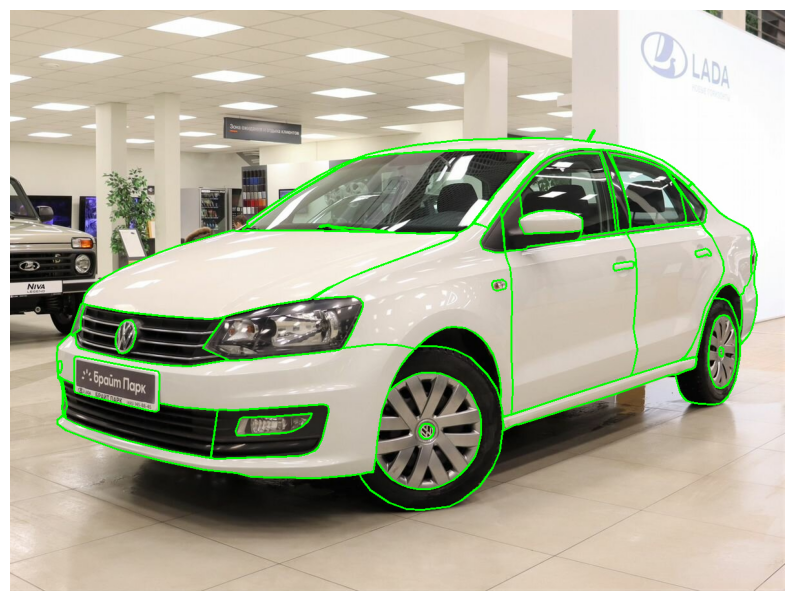

In [39]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "polo/items/1.jfif"  
label_txt_path = "dataset/labels/1.txt"


def visualize_polygons(image_path, label_txt_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Не удалось загрузить изображение {image_path}")
        return

    image_height, image_width, _ = img.shape

    if not os.path.exists(label_txt_path):
        print(f"Файл аннотаций не найден: {label_txt_path}")
        return

    with open(label_txt_path, "r") as label_file:
        annotations = label_file.readlines()

    for ann in annotations:
        ann_data = ann.split()
        if len(ann_data) < 2:
            continue 

        class_id = int(ann_data[0]) 
        coordinates = ann_data[1:]

        polygon = []
        for i in range(0, len(coordinates), 2):
            try:
                x = float(coordinates[i])
                y = float(coordinates[i + 1])
                x_pixel = int(x * image_width)
                y_pixel = int(y * image_height)
                polygon.append((x_pixel, y_pixel))
            except ValueError:
                print(f"Ошибка при обработке координат: {coordinates[i]} {coordinates[i+1]}")
                continue

        if polygon:
            cv2.polylines(img, [np.array(polygon)], isClosed=True, color=(0, 255, 0), thickness=2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

visualize_polygons(image_path, label_txt_path)
